<font color=green>
    
# Dogs vs Cats </font>

구글 드라이브 문서에 있는 dogs-vs-cats.zip을 다운받으셔서 압축을 풀고 진행하시면 됩니다.  
ResNet 모델을 설계해보세요!

   **< 목차 >**
1. Setting
 - 1) Import libraries
 - 2) Hyperparameters
2. Data
 - 1) Get Images
 - 2) Use DataLoader
 - 3) Check Images
3. Modeling
4. Loss Function & Optimizer
5. Train
 - 1) Train
 - 2) Test

## 1. Settings

#### 1) Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using PyTorch version: {torch.__version__}, Device: {device}')

Using PyTorch version: 1.8.1, Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

#### 2) Hyperparamters

In [4]:
# train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_data]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_data]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_data]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_data]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])
val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])


test_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_data]
test_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_data]

test_meanR = np.mean([m[0] for m in test_meanRGB])
test_meanG = np.mean([m[1] for m in test_meanRGB])
test_meanB = np.mean([m[2] for m in test_meanRGB])
test_stdR = np.mean([s[0] for s in test_stdRGB])
test_stdG = np.mean([s[1] for s in test_stdRGB])
test_stdB = np.mean([s[2] for s in test_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)
print(val_meanR, val_meanG, val_meanB)
print(val_stdR, val_stdG, val_stdB)
print(test_meanR, test_meanG, test_meanB)
print(test_stdR, test_stdG, test_stdB)

NameError: name 'train_data' is not defined

In [26]:
batch_size = 32
learning_rate = 0.001
epochs = 20
image_size = 224

# data augmentation
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.488, 0.450, 0.411], std=[0.223, 0.219, 0.218]),
])
valid_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.493, 0.453, 0.413], std=[0.223, 0.219, 0.218]),
])
test_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.486, 0.450, 0.411], std=[0.225, 0.220, 0.220]),
])

## 2. Data

#### 1) Get Images

In [27]:
# dir 각자 데이터 압축푼 폴더에 맞게 수정

train_dir = '../cat_dog_images/train'
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)

valid_dir = '../cat_dog_images/valid'
valid_data = datasets.ImageFolder(root=valid_dir, transform=valid_transforms)

test_dir = '../cat_dog_images/test'
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

#### 2) Use DataLoader

In [28]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)
    # drop_last 처리로 해줘야 하는 이유: 마지막에 배치에 안맞게 데이터 몇개 남을시 forward에서 view이후 size_mismatch오류가 일어남
print(f'train images: {len(train_loader.dataset)}')
print(f'valid images: {len(valid_loader.dataset)}')
print(f'test images: {len(test_loader.dataset)}')

train images: 20000
valid images: 2500
test images: 2500


#### 3) Check Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


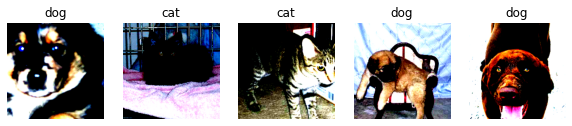

In [29]:
np.random.seed(42)
random_nums = [np.random.randint(1, 20001) for i in range(5)]

plt.figure(figsize=(10, 2))
for i in range(len(random_nums)):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(train_loader.dataset[random_nums[i]][0], (1,2,0)))
    plt.title(f'{"cat" if train_loader.dataset[random_nums[i]][1] == 0 else "dog"}')
    plt.axis('off')

## 3. Modeling

In [30]:
# activation function
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [31]:
#nn.Module을 상속받는 ResNet모델을 설계해보세요!
class BasicBlock(nn.Module): #nn.Module 상속받아 정의
    def __init__(self, in_planes, planes, stride = 1): #in_planes는 input으로 이용되는 데이터의 채널 수, planes는 필터의 갯수
        super(BasicBlock, self).__init__() #nn.Module의 메서드를 상속받습니다.
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes) #input의 분포가 달라짐에 따라 학습속도가 느려지는 것을 막기 위해 사용
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False) #위에서 통과한 결과값 사용
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential() #ResNet의 shortcut 정의
        if stride != 1 or in_planes != planes: #두번째 블럭부터 적용되는 shorcut
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x): #계산과정
        out = F.relu(self.bn1(self.conv1(x))) #conv연산과 Batch Nomarlization 연산을 진행하고 ReLU를 적용
        out = self.bn2(self.conv2(out)) #위에서 나온 값에 두번째 conv, BN을 적용
        out += self.shortcut(x) #결과값과 shorcut을 통과한 결과값을 더함
        out = F.relu(out) #shorcut까지 적용한 out에 relu적용
        return out
        
class ResNet(nn.Module):
    def __init__(self, num_classes = 2): #클래스 갯수 10개로 고정
        super(ResNet, self).__init__()
        self.in_planes = 16 #in_planes값을 16으로 고정
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False) #Basic Block의 conv1과 다름
        #input으로 이용하는 컬러 이미지에 적용하는 필터
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride): #여러 층의 레이어를 구성해 반환
        strides = [stride] + [1] * (num_blocks  - 1) #stride 범위를 BasicBlock마다 설정할 수 있도록 정의
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride)) #BasicBlock의 결과값을 추가
            self.in_planes = planes #in_planes를 plane로 업데이트(shorcut을 계산하기 위해)
        return nn.Sequential(*layers) #여러 층으로 생성한 레이어를 Sequential로 정의해 반환
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out) #input 16채널, output 16채널인 BasicBlock 2개
        out = self.layer2(out) #input 16채널, output 32채널인 BasicBlock 1개 #input 32채널, output 32채널인 BasicBlock 1개
        out = self.layer3(out) #input 32채널, output 64채널인 BasicBlock 1개 #input 64채널, output 64채널인 BasicBlock 1개
        out = F.avg_pool2d(out, 8) #다운샘플링
        out = out.view(out.size(0), -1) #일차원 벡터로 펼치기
        out = self.linear(out) #10개의 노드로 구성된 FC와 연결해 10 크기의 벡터 출력 #CIFAR-10 의 원핫 인코딩과 비교해 loss를 계산
        return out 

In [32]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [33]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=2, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

## 4. Loss_funtion & Optimizer

In [34]:
#model = resnet50().to(device)

In [35]:
import torchvision.models as models
model = models.resnet18(pretrained = True).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
#model.layer1[0].relu = Mish()
#model.layer2[0].relu = Mish()
#model.layer3[0].relu = Mish()
#model.layer4[0].relu = Mish()
#model.layer1[1].relu = Mish()
#model.layer2[1].relu = Mish()
#model.layer3[1].relu = Mish()
model.layer4[1].relu = Mish()
model = model.cuda()

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Train

#### **1) Train**

In [37]:
train_loss_arr = []
valid_loss_arr = []

for epoch in range(epochs):
    start = time.time()
    train_avg_loss = 0
    model.train()
    for image, label in train_loader:
        # ------- assign train data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        optimizer.zero_grad()
        output = model(image)
        # ------- backward prop
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        # ------- get train performance
        train_avg_loss += loss / len(train_loader)
    train_loss_arr.append(train_avg_loss)
    print(f'Epoch : {epoch+1}/{epochs}, train_loss : {train_avg_loss:.4f}', end=' / ')
     
    model.eval()
    with torch.no_grad():
        valid_acc=0
        valid_avg_loss =0
        for image, label in valid_loader:
            # ------- assign valid data
            image = image.to(device)
            label = label.to(device)
            # ------- forward prop
            val_output = model(image)
            val_loss = criterion(val_output,label)
            # ------- get valid performance
            val_batch_acc = ((val_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
            valid_acc += val_batch_acc / len(valid_loader) # acc / total_Iteration 
            valid_avg_loss += val_loss / len(valid_loader) # val_loss / total_Iteration
        valid_loss_arr.append(valid_avg_loss) 
        print(f'val_loss : {valid_avg_loss:.4f}, valid_acc : {valid_acc:.4f}, takes {time.time() - start}secs')

<ipython-input-30-c00e0ecebc6a>:10: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


Epoch : 1/20, train_loss : 0.0683 / val_loss : 0.0480, valid_acc : 0.9856, takes 334.9078369140625secs
Epoch : 2/20, train_loss : 0.0343 / val_loss : 0.0493, valid_acc : 0.9816, takes 331.4116711616516secs
Epoch : 3/20, train_loss : 0.0288 / val_loss : 0.0431, valid_acc : 0.9860, takes 339.8967864513397secs
Epoch : 4/20, train_loss : 0.0241 / val_loss : 0.0572, valid_acc : 0.9804, takes 334.60190176963806secs
Epoch : 5/20, train_loss : 0.0177 / val_loss : 0.0700, valid_acc : 0.9772, takes 330.52709007263184secs
Epoch : 6/20, train_loss : 0.0170 / val_loss : 0.0435, valid_acc : 0.9848, takes 331.2302362918854secs
Epoch : 7/20, train_loss : 0.0132 / val_loss : 0.0590, valid_acc : 0.9840, takes 322.73681235313416secs
Epoch : 8/20, train_loss : 0.0142 / val_loss : 0.0682, valid_acc : 0.9792, takes 318.73883056640625secs
Epoch : 9/20, train_loss : 0.0131 / val_loss : 0.0538, valid_acc : 0.9832, takes 319.5533015727997secs
Epoch : 10/20, train_loss : 0.0121 / val_loss : 0.0616, valid_acc : 0

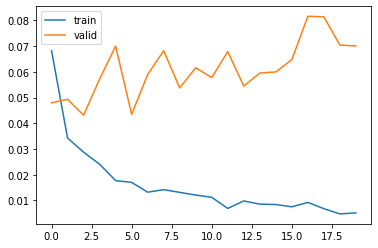

In [38]:
plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

#### **2) Test**

In [39]:
with torch.no_grad():
    start = time.time()
    test_acc=0
    model.eval()
    for image, label in test_loader:
        # ------- assign valid data
        image = image.to(device)
        label = label.to(device)
        # ------- forward prop
        test_output = model(image)
        # ------- get valid performance
        test_batch_acc = ((test_output.argmax(dim=1) == label).float().mean()) # acc = 맞춘 개수 / 배치사이즈
        test_acc += test_batch_acc / len(test_loader) # acc / total_Iteration 
    print(f'test_acc : {test_acc:.4f}, takes {time.time() - start}secs')

test_acc : 0.9864, takes 22.54240655899048secs


In [ ]:
# resnet18(no custom) - 16 - test_acc : 0.9772
# resnet18(mish custom) - 16 - test_acc : 0.9768
# resnet18(no custom) - 32 - test_acc : 0.9784
# resnet18(mish custom) - 32 - test_acc : 0.9864

**Fin** ────────────────────────────────────────────────────────────────────────────────────────────────